<a href="https://colab.research.google.com/github/acse-csp17/ci_mpm/blob/master/Keras_Conv_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# complex version cnn

In [ ]:
!pip install livelossplot 
!pip install radiant_mlhub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 19.4 MB/s 
     |████████████████████████████████| 381 kB 99.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 23.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import re
from glob import glob
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from radiant_mlhub import Dataset, Collection, client

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image as pil_image

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
import os

os.environ['MLHUB_API_KEY'] = 'b30b535bc53552671bec10fed8281299722f8276fb9d69e6511ff5ef44d89f31'
# downloading assets as done in tutorial notebook
download_dir = Path('~/Downloads').expanduser().resolve()

dataset = Dataset.fetch('nasa_tropical_storm_competition')

In [ ]:
archive_paths = dataset.download(output_dir=download_dir)

for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

  0%|          | 0/1446.5 [00:00<?, ?M/s]

  0%|          | 0/918.3 [00:00<?, ?M/s]

  0%|          | 0/7.5 [00:00<?, ?M/s]

  0%|          | 0/4.6 [00:00<?, ?M/s]

Extracting /root/Downloads/nasa_tropical_storm_competition_train_source.tar.gz...
Extracting /root/Downloads/nasa_tropical_storm_competition_test_source.tar.gz...
Extracting /root/Downloads/nasa_tropical_storm_competition_train_labels.tar.gz...
Extracting /root/Downloads/nasa_tropical_storm_competition_test_labels.tar.gz...
Done


In [ ]:
train_data = []

train_source = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'

jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)


    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed']),
        jpg_path
    ])

train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed', 'path']
).sort_values(by=['Image ID']).reset_index(drop=True)

train_df.head()

test_data = []

test_source = 'nasa_tropical_storm_competition_test_source'

jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        jpg_path
    ])

test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'path']
).sort_values(by=['Image ID']).reset_index(drop=True)

test_df.head()

,Image ID,Storm ID,Relative Time,Ocean,path
0,acd_123,acd,304198,1,/root/Downloads/nasa_tropical_storm_competitio...
1,acd_124,acd,305998,1,/root/Downloads/nasa_tropical_storm_competitio...
2,acd_125,acd,307798,1,/root/Downloads/nasa_tropical_storm_competitio...
3,acd_126,acd,309598,1,/root/Downloads/nasa_tropical_storm_competitio...
4,acd_127,acd,313198,1,/root/Downloads/nasa_tropical_storm_competitio...


In [97]:
# generate example tensor set of storm ID: abs
wind = train_df[train_df["Storm ID"] == 'abs']

#data transformation
from torchvision import transforms
train = [] #actual data
test=[] #64x64 test data
labels = []#relative time

for filename in wind.path:
  f = np.array(pil_image.open(filename).convert('L')).astype(float) #read image file as numpy array, convert into 8 bytes grey scale
  t = np.array(pil_image.open(filename).convert('L')).astype(float)
  train.append(f)
  test.append(t)

for t in wind["Relative Time"]:
  labels.append(t)


np.shape(train)

(57, 366, 366)

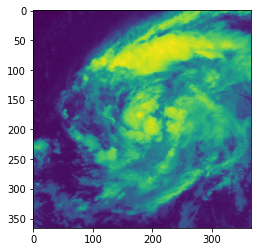

In [103]:
plt.imshow(test[0])

# We only use 300 data instead of 1200 data because of the limitation of the computation of our computer, if we have more time, we would like to use all data and a bigger epoch number so that we can get a accurate model.

###  convolutional encoder

In [104]:
train = np.reshape(train,(np.shape(train)[0],np.shape(train)[1],np.shape(train)[2],1))
#train = np.moveaxis(train,1,2)

In [105]:
test = np.reshape(test,(np.shape(test)[0],np.shape(test)[1],np.shape(test)[2],1))
#test = np.moveaxis(test,1,2)

In [106]:
mean = np.mean(train[:][:][:].flatten()).item()/255.
std = np.std(test[:][:][:].flatten()).item()/255.
def apply_standardization(X):
  X /=255.
  X -=mean
  X /=std
  return X

#standaridize data
train = apply_standardization(train)
test = apply_standardization(test)

In [108]:
np.shape(test)

(57, 366, 366, 1)

In [109]:
train=train.astype(float)

In [110]:
test=test.astype(float)

# We tried a very complex CNN model, we added many different type of layers:
- MaxPool2D: Applies a 2D max pooling over an input signal composed of several input planes
- Conv2D: Applies a 2D convolution over an input signal composed of several input planes
- UpSampling2D: Repeats the rows and columns of the data by size[0] and size[1] respectively.
- Cropping2D: It crops along spatial dimensions, i.e. height and width.

### The theory behind it is that It can better retain the connected information between the pixels of an image. The convolution step creates many small pieces called the feature maps or features. These squares preserve the relationship between pixels in the input image. 

In [114]:
tf.random.set_seed(42)
np.random.seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)


conv_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(366, 366, 1)),
    keras.layers.Conv2D(4, kernel_size=(10,10), padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(5, 5), padding="SAME"),
    keras.layers.Conv2D(8, kernel_size=(2,2), padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(3, 3), padding="SAME"),
    keras.layers.Conv2D(8, kernel_size=(3,3), padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(3, 3), padding="SAME"),
    keras.layers.Conv2D(8, kernel_size=(3,3), padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2, 2), padding="SAME"),
    keras.layers.Flatten(),
    keras.layers.Dense(30),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Dense(256, input_shape=[30], activation="relu"),
    keras.layers.Reshape(target_shape=(16, 16, 1)),
    keras.layers.Conv2D(8, kernel_size=(2,2), padding="SAME", activation="relu"),
    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Conv2D(8, kernel_size=(2,2), padding="SAME", activation="relu"),
    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Cropping2D(cropping=((3, 0), (3, 0)), data_format=None),
    keras.layers.Conv2D(8, kernel_size=(2,2), padding="SAME", activation="relu"),
    keras.layers.UpSampling2D(size=(2, 2)),    
    keras.layers.Conv2D(4, kernel_size=(3,3), padding="SAME", activation="relu"),
    keras.layers.UpSampling2D(size=(3, 3)),
    keras.layers.Conv2D(1, kernel_size=(10,10), padding="SAME", activation="sigmoid"),
    ])


conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="mse", 
                optimizer=keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999))

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_398 (Conv2D)         (None, 366, 366, 4)       404       
                                                                 
 max_pooling2d_176 (MaxPooli  (None, 74, 74, 4)        0         
 ng2D)                                                           
                                                                 
 conv2d_399 (Conv2D)         (None, 74, 74, 8)         136       
                                                                 
 max_pooling2d_177 (MaxPooli  (None, 25, 25, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_400 (Conv2D)         (None, 25, 25, 8)         584       
                                                                 
 max_pooling2d_178 (MaxPooli  (None, 9, 9, 8)       

In [115]:
start = time.time()
history = conv_ae.fit(train,
                      train, 
                      epochs=40, 
                      validation_data=(test, test),
                      verbose=2,
                      callbacks=[early_stopping]
                     )
end = time.time()
print(f"the execution time of cnn autoencoder is {end - start}")

Epoch 1/40
2/2 - 1s - loss: 1.1181 - val_loss: 0.8798 - 1s/epoch - 618ms/step
Epoch 2/40
2/2 - 0s - loss: 0.8720 - val_loss: 0.7878 - 225ms/epoch - 112ms/step
Epoch 3/40
2/2 - 0s - loss: 0.7734 - val_loss: 0.7474 - 232ms/epoch - 116ms/step
Epoch 4/40
2/2 - 0s - loss: 0.7471 - val_loss: 0.7449 - 230ms/epoch - 115ms/step
Epoch 5/40
2/2 - 0s - loss: 0.7425 - val_loss: 0.7359 - 227ms/epoch - 113ms/step
Epoch 6/40
2/2 - 0s - loss: 0.7365 - val_loss: 0.7338 - 234ms/epoch - 117ms/step
Epoch 7/40
2/2 - 0s - loss: 0.7332 - val_loss: 0.7304 - 227ms/epoch - 114ms/step
Epoch 8/40
2/2 - 0s - loss: 0.7298 - val_loss: 0.7275 - 227ms/epoch - 113ms/step
Epoch 9/40
2/2 - 0s - loss: 0.7271 - val_loss: 0.7247 - 225ms/epoch - 113ms/step
Epoch 10/40
2/2 - 0s - loss: 0.7243 - val_loss: 0.7212 - 224ms/epoch - 112ms/step
Epoch 11/40
2/2 - 0s - loss: 0.7289 - val_loss: 0.7205 - 227ms/epoch - 114ms/step
Epoch 12/40
2/2 - 0s - loss: 0.7204 - val_loss: 0.7167 - 224ms/epoch - 112ms/step
Epoch 13/40
2/2 - 0s - loss:

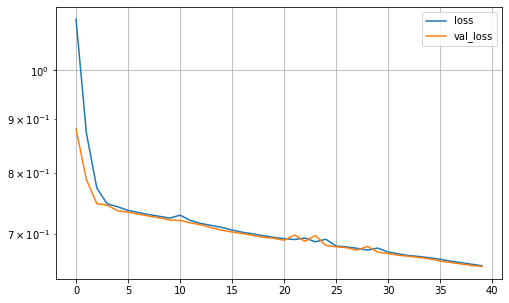

In [116]:
# print(history_conv.history.keys())
# print('best value: ', conv_ae.evaluate(train, train, verbose=0))

pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [ ]:
from numpy.linalg import inv

def covariance_matrix(X):
    means = np.array([np.mean(X, axis = 1)]).transpose()
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.transpose())/(X.shape[1]-1)
    return res

def update_prediction(x, K, H, y):
    res = x + np.dot(K,(y - np.dot(H, x)))
    return res  

def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H,np.dot(B,H.transpose())))
    res = np.dot(B,np.dot(H.transpose(),tempInv))
    return res

def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs,y_pred)).mean()

In [ ]:
encoder = conv_encoder
decoder = conv_decoder

model_data_compr = encoder.predict(model_data)
sensors_data_compr = encoder.predict(sensors_data)

print(f"Model data size: {model_data_compr.shape}")
print(f"Sensors data size: {sensors_data_compr.shape}")

Model data size: (5, 30)
Sensors data size: (5, 30)


In [ ]:
latent_space = 30  #size of the compressed variables#################
nNodes = latent_space 
I = np.identity(nNodes)
R = 0.001*I #np.cov(sensors_data_compr.T) or covariance_matrix(np.array(sensors_data_compr).T) #Observation error covariance
H = I #Observation operator
B = np.cov(model_data_compr.T) #covariance_matrix(np.array(model_data_compr).T) #Background error covariance

In [ ]:
print('Start Assimilation')
start = time.time()

K = KalmanGain(B, H, R) 

updated_data_list = []
for i in range(len(model_data_compr)):
    updated_data = update_prediction(model_data_compr[i], K, H, sensors_data_compr[i]) #compute only the analysis
    updated_data_list.append(updated_data)
updated_data_compr = np.array(updated_data_list)

mse_before_DA_latent = mse(sensors_data_compr, model_data_compr)
mse_after_DA_latent = mse(sensors_data_compr, updated_data_compr)

end = time.time()   

print('MSE before assimilation for the compressed data: ', mse_before_DA_latent)
print('MSE after assimilation for the compressed data: ', mse_after_DA_latent)
print(f'Time for assimilation: {end-start} seconds')

Start Assimilation
MSE before assimilation for the compressed data:  0.84247756
MSE after assimilation for the compressed data:  0.21846668776188982
Time for assimilation: 0.001583099365234375 seconds


In [ ]:
# Decompress (reconstruct) the updated, model and sensor data with the decoder
decompressed_model_data = decoder.predict(model_data_compr)
decompressed_sensors_data = decoder.predict(sensors_data_compr)
decompressed_updated_data_array = decoder.predict(updated_data_compr)

mse_before_DA = mse(sensors_data, model_data)
mse_after_DA = mse(sensors_data.flatten(), decompressed_updated_data_array.flatten())

print('MSE before assimilation for the decompressed data: ', mse_before_DA)
print('MSE after assimilation for the decompressed data: ', mse_after_DA)


MSE before assimilation for the decompressed data:  0.1252468804347963
MSE after assimilation for the decompressed data:  0.08529647641403636


In [ ]:
# save our model
conv_ae.save("sibo_autoencoder_cnn_model.h5")
conv_encoder.save("sibo_encoder_cnn_model.h5")
conv_decoder.save("sibo_decoder_cnn_model.h5")